## **Load Dataset**

In [1]:
import pandas
import numpy as np
import pandas as pd
import os
import keras
from keras.initializers import glorot_uniform
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Input, ZeroPadding2D,Activation,MaxPooling2D,Add,AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from tensorflow.keras import layers
from keras import regularizers
from keras.utils import np_utils
from keras import callbacks
import tensorflow as tf
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.transform import resize
EPOCHS = 50 

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
cd /content/drive/MyDrive/enel

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nehagianchandani","key":"7b673be8a7471e8fb085618aeed0c4db"}'}

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d grassknoted/asl-alphabet


 99% 1.02G/1.03G [00:07<00:00, 135MB/s]
100% 1.03G/1.03G [00:07<00:00, 146MB/s]


In [ ]:
testfile = './asl_alphabet_test/asl_alphabet_test'
trainfile = './asl_alphabet_train/asl_alphabet_train'

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")

### **To load on Colab**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#testfile = '/content/drive/MyDrive/enel/archive_lessdata\asl_alphabet_test\asl_alphabet_test'
trainfile = '/content/gdrive/MyDrive/archive_lessdata_new2'

### **Plot one picture to test the dataset**

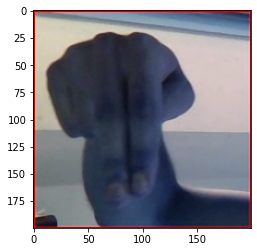


 (200, 200, 3)


In [3]:
ex = cv2.imread('/content/gdrive/MyDrive/archive_lessdata_new2/N/N10.jpg')
plt.imshow(ex)
plt.show()
print('\n',ex.shape)

## **Image processing**

**Change RGB images to gray scale**

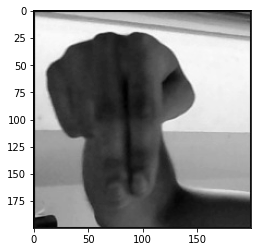

In [4]:
from skimage import color

ex1 = cv2.cvtColor(ex, cv2.COLOR_BGR2GRAY)
plt.imshow(ex1,cmap = 'gray')

### **Denoising**

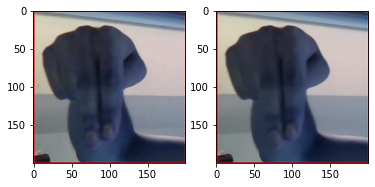

In [5]:
def denoise(image):
    
    denoised_image = cv2.fastNlMeansDenoisingColored(image,None,h=2)
    
    return denoised_image

denoise_ex = denoise(ex)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(ex)
plt.subplot(1,2,2)
plt.imshow(denoise_ex)

**Visualization**

dataset includes images of 3d ndarray and the shape of (200, 200) with a color image as the size 3

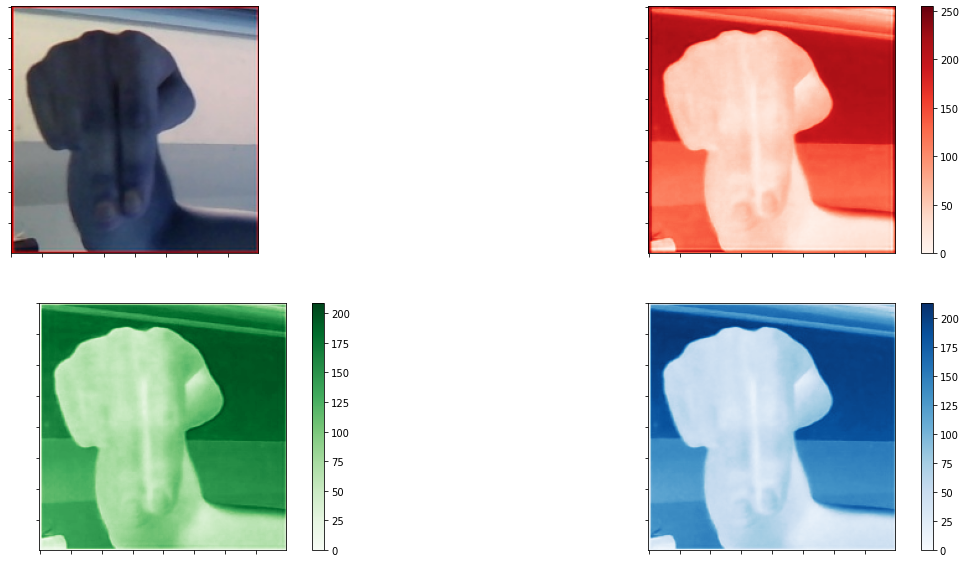

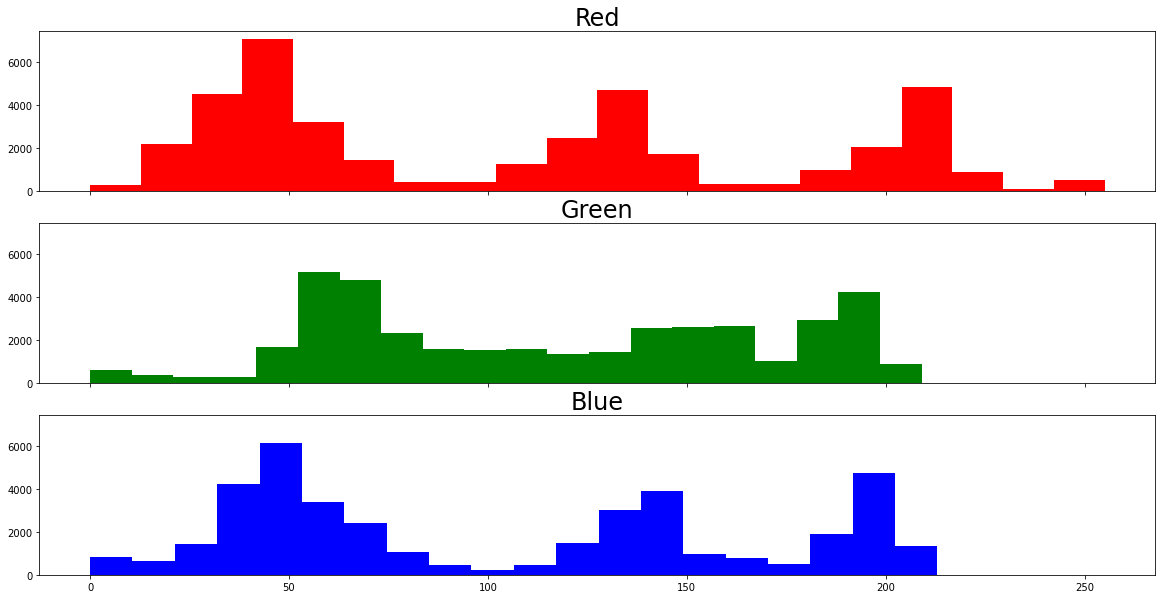

In [6]:
# Color of the image
red = ex[:, :, 0]
blue= ex[:, :, 1]
green = ex[:,:,2]


#Set up the figure for plotting
fig, axs = plt.subplots(2,2, figsize=(20, 10))

cax_00 = axs[0,0].imshow(ex)
axs[0,0].xaxis.set_major_formatter(plt.NullFormatter())  # kill xlabels
axs[0,0].yaxis.set_major_formatter(plt.NullFormatter())  # kill ylabels

cax_01 = axs[0,1].imshow(red, cmap='Reds')
fig.colorbar(cax_01, ax=axs[0,1])
axs[0,1].xaxis.set_major_formatter(plt.NullFormatter())
axs[0,1].yaxis.set_major_formatter(plt.NullFormatter())

cax_10 = axs[1,0].imshow(green, cmap='Greens')
fig.colorbar(cax_10, ax=axs[1,0])
axs[1,0].xaxis.set_major_formatter(plt.NullFormatter())
axs[1,0].yaxis.set_major_formatter(plt.NullFormatter())

cax_11 = axs[1,1].imshow(blue, cmap='Blues')
fig.colorbar(cax_11, ax=axs[1,1])
axs[1,1].xaxis.set_major_formatter(plt.NullFormatter())
axs[1,1].yaxis.set_major_formatter(plt.NullFormatter())
plt.show()

#Plot histograms
fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(20, 10))

axs[0].hist(red.ravel(), bins=20, color = 'red')
axs[0].set_title('Red',fontsize=24)
axs[1].hist(green.ravel(), bins=20, color = 'green')
axs[1].set_title('Green',fontsize=24)
axs[2].hist(blue.ravel(), bins=20, color = 'blue')
axs[2].set_title('Blue',fontsize=24)

plt.show()


*   Preprocess images(resize,denoise,enhance contrast)
*   Defining a dictionary which contains labels and its mapping to a number which acts as class label.
*   loading image data and labels and then mapping those labels to the dictionary defined before.
*   Normalizing image data.
*   converting labels to one hot format as our keras model don't accept categorical label.
*   Normalizing image data.
*   creating training and test data by splitting original data into 95% of training data and 5% testing data.







In [7]:
labels_dict = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,'Z':25,'space':26,'del':27,'nothing':28}

def load_data():

    """
    Loads sign language dataset.
    """
    path = r"/content/gdrive/MyDrive/archive_lessdata_new2"
    images, labels = [], []
    for folder in os.listdir(path):
        
        print(folder, end = ' | ')
        #print(trainfile+"\\"+ folder)
        for image in os.listdir(path+"/"+ folder):
            temp_img = cv2.imread(path+"/"+folder+"/"+image)
            temp_img = cv2.fastNlMeansDenoisingColored(temp_img,None,h=2)
            temp_img = cv2.resize(temp_img, (128,128))
            images.append(temp_img)
            labels.append(labels_dict[folder])

    #convert images to numpy array and normalize        
    images = np.array(images)
    images = images.astype('float32')/255.0
    
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.1, random_state=42)
    
    
    print()
    print('Loaded', len(X_train),'images for training,','Train data shape =',X_train.shape)
    print('Loaded', len(X_test),'images for testing','Test data shape =',X_test.shape)
    
    return X_train, X_test, y_train, y_test

In [8]:
X_train, X_test, y_train, y_test = load_data()

y_train_ = keras.utils.np_utils.to_categorical(y_train,29)
y_test_ = keras.utils.np_utils.to_categorical(y_test,29)

S | X | Z | R | U | V | W | space | Y | T | K | L | O | nothing | M | N | P | I | Q | J | A | D | del | H | C | E | F | G | B | 
Loaded 9135 images for training, Train data shape = (9135, 128, 128, 3)
Loaded 1015 images for testing Test data shape = (1015, 128, 128, 3)


In [9]:
print("X_train shape  -> ", X_train.shape)
print("X_test shape   -> ", X_test.shape)
print("y_train_ shape -> ", y_train_.shape)
print("y_test_ shape  -> ", y_test_.shape)
print("len y_train    -> ", len(y_train))

X_train shape  ->  (9135, 128, 128, 3)
X_test shape   ->  (1015, 128, 128, 3)
y_train_ shape ->  (9135, 29)
y_test_ shape  ->  (1015, 29)
len y_train    ->  9135


In [10]:
print(X_train.min(),X_train.max(),X_train.mean(),X_train.std())
print(X_test.min(),X_test.max(),X_test.mean(),X_test.std())

0.0 0.99607843 0.51031184 0.24672961
0.0 0.99607843 0.5071362 0.2483421


### **Data Augmentation**

In [ ]:
batch_size = 32
gen_params = {"featurewise_center":False, "samplewise_center":False, "featurewise_std_normalization":False,\
              "samplewise_std_normalization":False, "zca_whitening":False, "rotation_range":15,\
              "width_shift_range":0, "height_shift_range":0, "shear_range":0, \
              "zoom_range":0, "fill_mode":'constant', "horizontal_flip":False, "vertical_flip":False
              }

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params, preprocessing_function = tf.keras.applications.mobilenet.preprocess_input)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params, preprocessing_function = tf.keras.applications.mobilenet.preprocess_input)

train_gen.fit(X_train,seed = 1)
val_gen.fit(X_test, seed = 1)

train_flow = train_gen.flow(X_train,y_train,batch_size = batch_size)
val_flow = val_gen.flow(X_test,y_test,batch_size = batch_size) 

In [ ]:
plt.figure(figsize = (32,24))
Xbatch,Ybatch = train_flow.__getitem__(0)
print(Xbatch.mean(),Xbatch.std())
print(Xbatch.min(),Xbatch.max())
for ii in range(batch_size):
    plt.subplot(7,5,ii+1)
    plt.imshow((Xbatch[ii]- Xbatch[ii].min())/(Xbatch.max() - Xbatch[ii].min()), cmap = "gray")
    plt.title(y_train[ii])
plt.show()

## **Optimal Sequential Implementation**

In [11]:
def create_model(optimizer): 
    # create model 
    model = Sequential([
    layers.experimental.preprocessing.RandomRotation(0.2, input_shape=(128, 128, 3)),
    layers.Conv2D(128, 3, padding='same', input_shape=(128, 128, 3), activation='relu'),
    layers.MaxPool2D(2),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPool2D(2),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPool2D(2),
    layers.Flatten(),
    layers.Dense(128),
    layers.Dense(29, activation='softmax')
    ])
    
    model.compile(optimizer = optimizer, loss = keras.losses.categorical_crossentropy, metrics = ["accuracy"])
    
    # Summarize the model
    model.summary()
    return model

In [12]:
def fit_model(model,epochs):
    
    earlystopping = callbacks.EarlyStopping(monitor = 'val_loss', min_delta=0.001, # minimium amount of change to count as an improvement
    patience=23, # how many epochs to wait before stopping
    restore_best_weights = True)
    
    model_hist = model.fit(X_train, y_train_, batch_size = 50, epochs = epochs, validation_split = 0.1, callbacks =[earlystopping])
    
    return model_hist

In [13]:
print('Train and Baseline Model with adam Optimizer and',50,' epochs') 
model = create_model(optimizer = 'adam')

Train and Baseline Model with adam Optimizer and 50  epochs
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation (RandomRota  (None, 128, 128, 3)      0         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                          

In [14]:
history = fit_model(model, 50)

Epoch 1/50
165/165 [==============================] - 40s 175ms/step - loss: 3.3597 - accuracy: 0.0657 - val_loss: 3.0862 - val_accuracy: 0.1313
Epoch 2/50
165/165 [==============================] - 28s 167ms/step - loss: 2.8275 - accuracy: 0.1910 - val_loss: 2.4750 - val_accuracy: 0.2637
Epoch 3/50
165/165 [==============================] - 28s 167ms/step - loss: 2.2914 - accuracy: 0.3208 - val_loss: 1.9248 - val_accuracy: 0.4103
Epoch 4/50
165/165 [==============================] - 28s 168ms/step - loss: 1.9085 - accuracy: 0.4215 - val_loss: 1.6384 - val_accuracy: 0.5044
Epoch 5/50
165/165 [==============================] - 28s 168ms/step - loss: 1.6313 - accuracy: 0.4995 - val_loss: 1.4265 - val_accuracy: 0.5427
Epoch 6/50
165/165 [==============================] - 28s 169ms/step - loss: 1.4271 - accuracy: 0.5627 - val_loss: 1.3071 - val_accuracy: 0.5886
Epoch 7/50
165/165 [==============================] - 28s 168ms/step - loss: 1.2675 - accuracy: 0.6073 - val_loss: 1.1493 - val_ac

In [25]:
def plot_performance(hist_model):
    
    plt.plot(hist_model.history['accuracy'])
    plt.plot(hist_model.history['val_accuracy'])
    plt.legend(['training accuracy', 'validation accuracy'], loc='lower right')
    plt.title('accuracy plot - training vs validation')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.savefig('Acc_lowweightSeq.jpg', dpi=450)
    plt.show()
    
    plt.plot(hist_model.history['loss'])
    plt.plot(hist_model.history['val_loss'])
    plt.legend(['training loss', 'validation loss'], loc = 'upper right')
    plt.title('loss plot - training vs validation')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.savefig('Loss_lowweightSeq.jpg', dpi=450)
    plt.show()

 Model with preprocesisng with adam Optimizer and 50  epochs


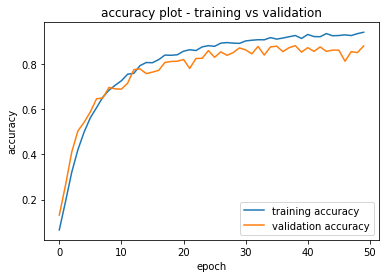

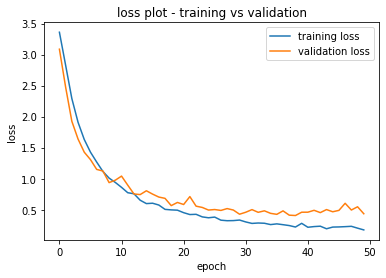

In [26]:
print(' Model with preprocesisng with adam Optimizer and',EPOCHS,' epochs') 
plot_performance(history)

In [16]:
def save_model(model, name):
      model_to_save = model
      model_to_save.save(name + '.h5')
      print("Model successfully Saved.")

save_model(model, "Sequential-LowWeight_Optimized")

Model successfully Saved.


In [17]:
def evaluate_model(model):
    test_loss,test_acc = model.evaluate(X_test, y_test_)
    print('Test accuracy:', test_acc)
    print('Test loss:', test_loss)
    
evaluate_model(model)

32/32 [==============================] - 2s 56ms/step - loss: 0.3629 - accuracy: 0.8936
Test accuracy: 0.8935960531234741
Test loss: 0.3628842532634735


### **GRAD-CAM Visualization**

In [ ]:
# can skip this cell
model = "/content/drive/MyDrive/Sequential-LowWeight.h5"
model = keras.models.load_model(model)

In [19]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
        

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()
    heatmap_resized = resize(heatmap,(128, 128))
    return heatmap_resized

In [20]:
from tensorflow import keras as K
last_conv_layer_name = list(filter(lambda x: isinstance(x, 
                                                        K.layers.Conv2D), 
                                   model.layers))[-1].name
print(last_conv_layer_name)

conv2d_2


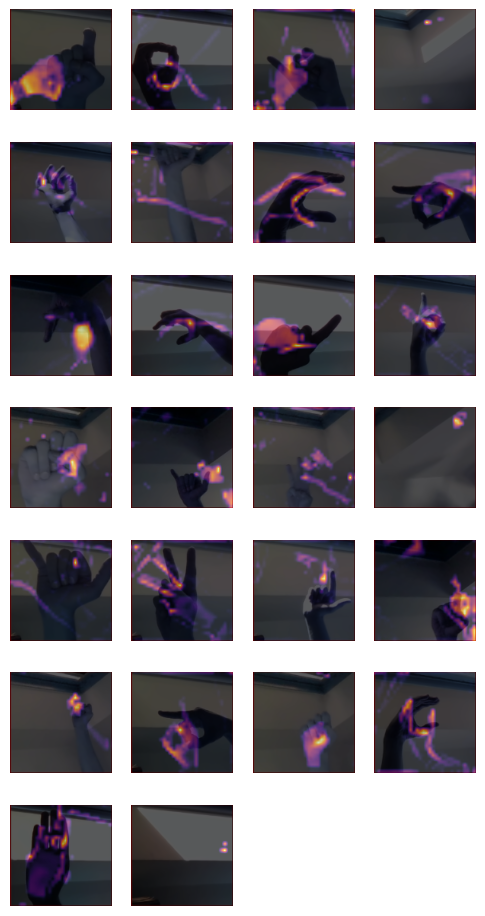

In [21]:
# Remove last layer's 
model.layers[-1].activation = None

plt.figure(figsize = (6,12),dpi = 100)

for ii in range (26):
    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(X_test[ii][np.newaxis,:,:], model, last_conv_layer_name)
    plt.subplot(7,4,ii+1)
    plt.imshow(X_test[ii])
    plt.imshow(heatmap, alpha = 0.65, cmap = "inferno")
    #plt.colorbar()
    plt.axis("off")
plt.savefig('GRAD-CAM_Sequential-LowWeight_Optimized.jpg', dpi=300)
plt.show()


# Result visualizations and confusion matrix


In [22]:
predicted_classes = np.argmax(model.predict(X_test), axis=-1)

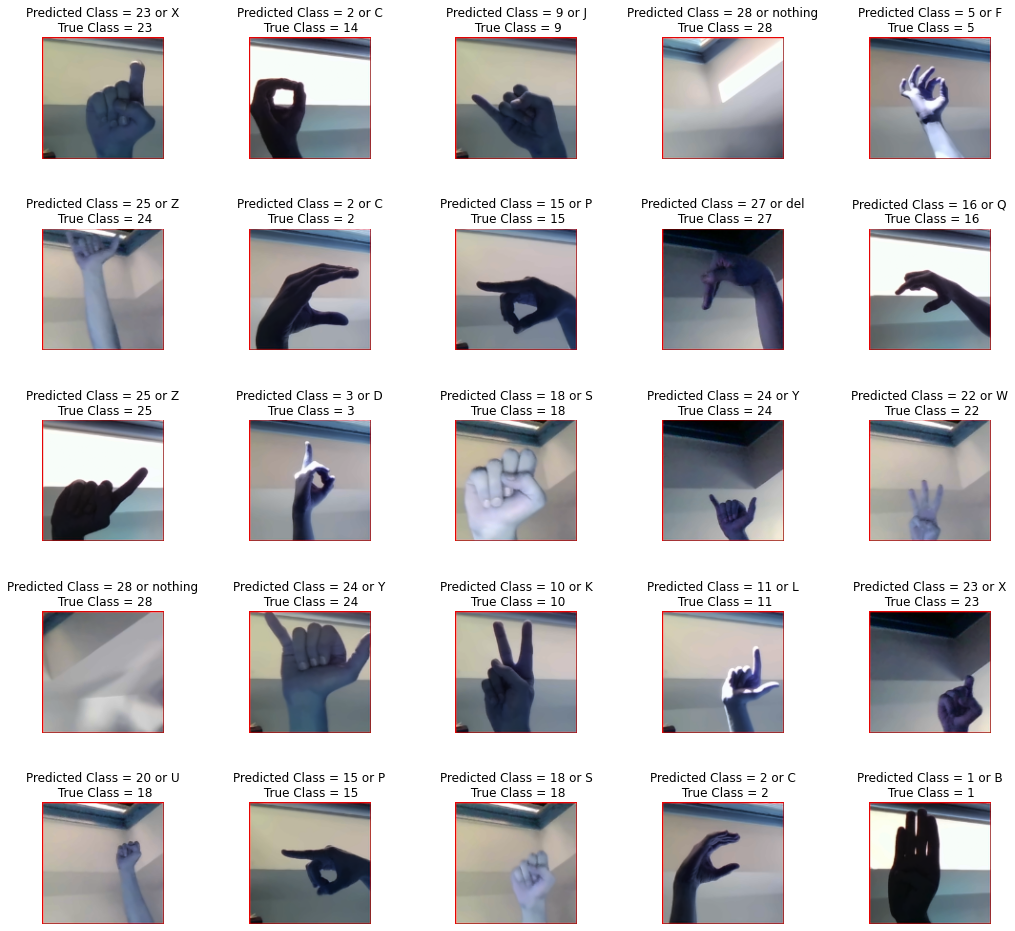

In [23]:
#Visualize predictions
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (17, 17))
axes = axes.ravel()

for i in np.arange(0, L * W):  
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"Predicted Class = {predicted_classes[i]} or {dict((v,k) for k,v in labels_dict.items()).get(predicted_classes[i])}\n True Class = {y_test[i]}")
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.7)

plt.savefig('predictions_lowweightSeq.jpg', dpi=300)

Confusion matrix, without normalization


<Figure size 1440x1440 with 0 Axes>

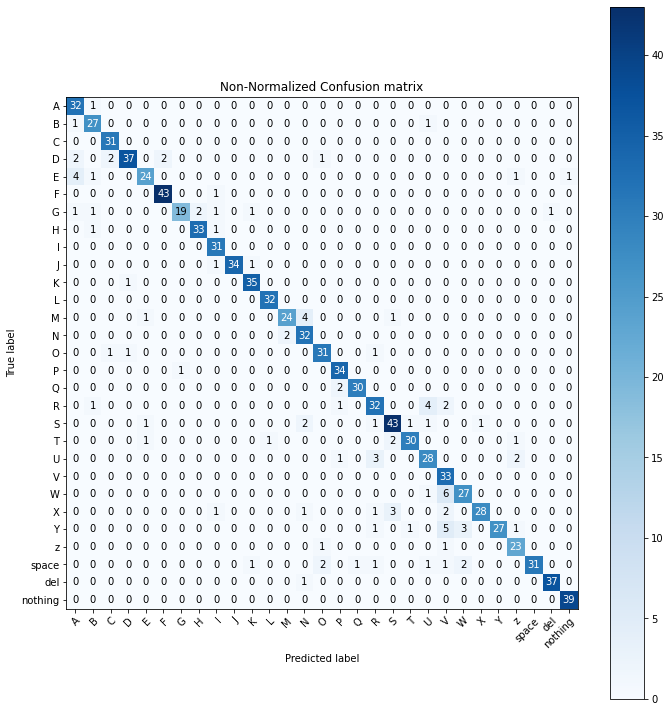

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, predicted_classes)

#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Computing confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

# Visualizing
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(29),
           yticks=np.arange(29),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

   # Rotating the tick labels and setting their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Looping over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

#Specifying class labels
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'z', 'space', 'del', 'nothing']

#Non-Normalized Confusion Matrix
plt.figure(figsize=(20,20))
plot_confusion_matrix(y_test, predicted_classes, classes = class_names, title='Non-Normalized Confusion matrix')
plt.savefig('confmatrix_Sequential-LowWeight_Optimized', dpi=300)
plt.show()
